# Measure model accuracy

### on ImageNet, COCO and LAION datasets

## Imports

In [1]:
import torch
import numpy as np

from tqdm import tqdm

from src import metrics
from src.utils import (
    _train, _intervene, measure_everything,
    get_modality_gap,
    get_coco, get_laion, get_imagenet,
)

import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda:1" if torch.cuda.is_available() else "cpu"

## Definitions

In [2]:
use_model = "siglip" # siglip or siglip2

In [3]:
if use_model == "clip":
    model_name = "openai/clip-vit-base-patch32"
    d_model = 512
    beta = 4e-4
elif use_model == "clip-L":
    model_name = "openai/clip-vit-large-patch14"
    d_model = 768
    beta = 1e-4
elif use_model == "openclip":
    model_name="laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
    d_model = 512
    beta = 4e-4
elif use_model == "openclip-L":
    model_name="laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
    d_model = 768
    beta = 2e-4
elif use_model == "siglip":
    model_name = "google/siglip-base-patch16-224"
    d_model = 768
    beta = 1e-4
elif use_model == "siglip2":
    model_name = "google/siglip2-base-patch16-224"
    d_model = 768
    beta = 7e-5
else:
    raise NotImplementedError(f"Model {use_model} not recognized.")

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=1.27s)
creating index...
index created!


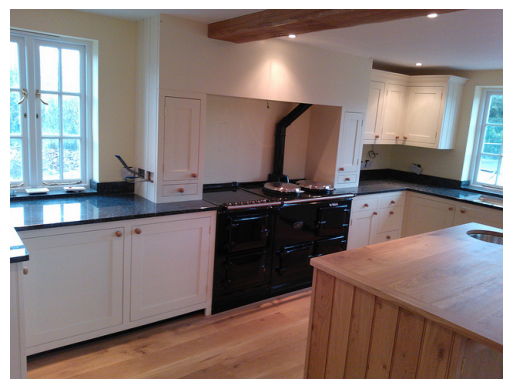

Caption: A modern kitchen with a huge black wood burning range.


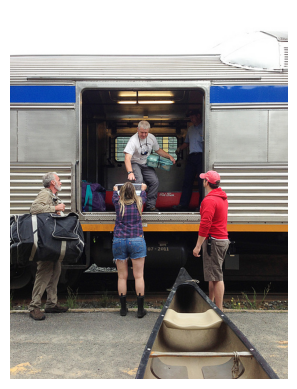

Caption: Several people loading baggage into the open side door of a train.


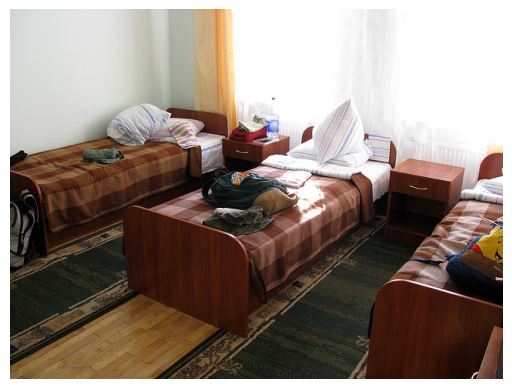

Caption: Bedroom with three single beds same coverings. 


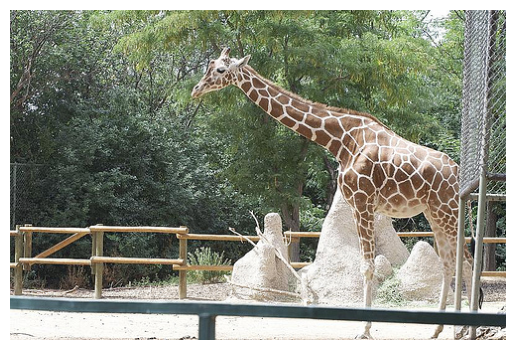

Caption: a large giraffe that is in side of a fence


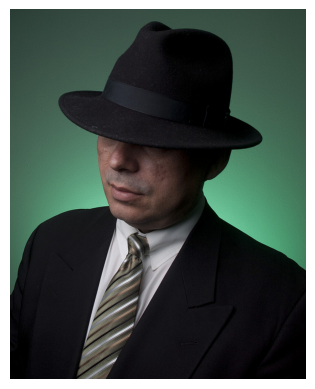

Caption: A picture of a man in a suit, tie and hat. 


<Figure size 640x480 with 0 Axes>

In [4]:
laion_loader = get_laion(device=device, model_name=model_name)
coco_loader = get_coco(device=device, model_name=model_name)
imagenet_test_loader, class_embeddings = get_imagenet(batch_size=512, model_name=model_name, device=device)
imagenet_train_loader, class_embeddings = get_imagenet(batch_size=512, model_name=model_name, device=device, split="train")
imagenet_train_labels = imagenet_train_loader.dataset.tensors[1]
imagenet_test_labels  = imagenet_test_loader.dataset.tensors[1]

def make_dummy_loader(embeddings):
    """
    Create a dummy DataLoader for the given embeddings.
    """
    dataset = torch.utils.data.TensorDataset(embeddings, torch.zeros_like(embeddings))
    return torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)

dummy_class_loader = make_dummy_loader(class_embeddings)
labels = imagenet_test_loader.dataset.tensors[1]
T_ImageNet = class_embeddings[labels]

mu_laion_I = laion_loader.dataset.tensors[0].mean(dim=0)
mu_laion_T = laion_loader.dataset.tensors[1].mean(dim=0)

In [5]:
# SSAE, SSAE_name, _ = _train(beta=, train_loader=laion_loader, model_name=model_name, d_model=d_model, archi="MP", device=device, top_k=50, expansion_factor=64) # Standard SAE
ASAE, ASAE_name, _ = _train(beta=beta, train_loader=laion_loader, model_name=model_name, d_model=d_model, archi="MP", device=device)#, force_retrain=True, save_quand_meme=True) # Aligned SAE

# SSAE.metrics = measure_everything(SSAE, laion_loader, device, return_sqr=True)
ASAE.metrics = measure_everything(ASAE, laion_loader, device, return_sqr=True)
# print(f"Energy per concept: {ASAE.metrics.E[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")
# print(f"Frequency per concept: {ASAE.metrics.f[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")
# print(f"Modality score per concept: {ASAE.metrics.mu[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")

Model name: google/siglip-base-patch16-224/laion_MP_centered_False_8_L0_20_alpha00beta00001.pt


100%|███████████████████████████████████████████████████████████████████████████████| 1390/1390 [00:22<00:00, 61.05it/s]


In [6]:
@torch.no_grad()
def recall(I, T, top_k=1, batch_size=256, shuffle=True): # , logit_scale=4.6052): useless for accuracy, doesn't change ordeging
    num_batches = I.shape[0] // batch_size
    
    correct_pairs = 0
    total_pairs = 0
    
    labels = torch.arange(batch_size, device=I.device)
    
    if shuffle:
        perm = torch.randperm(I.shape[0], device='cpu')
    for i in tqdm(range(num_batches)):
        I_batch = I[perm[i * batch_size:(i + 1) * batch_size]]
        T_batch = T[perm[i * batch_size:(i + 1) * batch_size]]

        # Compute cosine similarity
        I_batch = I_batch / (I_batch.norm(dim=1, keepdim=True) + 1e-8)
        T_batch = T_batch / (T_batch.norm(dim=1, keepdim=True) + 1e-8)
        logits_per_image = I_batch @ T_batch.T
        logits_per_text = T_batch @ I_batch.T

        logits_per_image = logits_per_image # * logit_scale
        logits_per_text = logits_per_text # * logit_scale
        
        topk_image = logits_per_image.topk(k=top_k, dim=1).indices
        topk_text = logits_per_text.topk(k=top_k, dim=1).indices

        correct_image = (topk_image == labels.unsqueeze(1)).any(dim=1).sum().item()
        correct_text = (topk_text == labels.unsqueeze(1)).any(dim=1).sum().item()
        
        correct_pairs += (correct_image + correct_text) / 2
        total_pairs += batch_size
        
    accuracy = correct_pairs / total_pairs
    return accuracy

@torch.no_grad()
def zero_shot_recall(test_loader, class_embeddings, modified_embeddings=None, top_k=1):
    if isinstance(class_embeddings, torch.utils.data.DataLoader):
        class_embeddings = class_embeddings.dataset.tensors[0]
    class_embeddings = class_embeddings.to(device)
    class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
    correct = 0
    total = 0
    for i, (images_features, labels) in enumerate(test_loader):
        if modified_embeddings is not None:
            images_features = modified_embeddings[i * test_loader.batch_size:(i + 1) * test_loader.batch_size]
        images_features = images_features.to(device)
        images_features /= images_features.norm(dim=-1, keepdim=True)
        labels = labels.to(device)
        
        logits = images_features @ class_embeddings.T
        topk = logits.topk(k=top_k, dim=1).indices
        
        correct += (topk == labels.unsqueeze(1)).any(dim=1).sum().item()
        total += labels.size(0)
        
    return correct / total

def train_linear_classifier(train_loader, num_classes, epochs=1):
    from torch.nn import Sequential, BatchNorm1d, Linear, CrossEntropyLoss
    from torch.optim import Adam
    from torch.optim.lr_scheduler import LambdaLR
    import matplotlib.pyplot as plt
    from IPython.display import display, clear_output

    in_dim = train_loader.dataset.tensors[0].shape[1]
    model = Sequential(
        BatchNorm1d(in_dim),
        Linear(in_dim, num_classes)
    ).to(device)

    base_lr = 1e-3
    optimizer = Adam(model.parameters(), lr=base_lr)
    criterion = CrossEntropyLoss()

    # Scheduler: warmup + cosine decay
    warmup_steps = 2000
    total_steps = len(train_loader) * 5

    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        decay_ratio = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + torch.cos(torch.tensor(decay_ratio * 3.1415926535)))

    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

    model.train()
    losses = []

    for epoch in range(epochs):
        pbar = tqdm(train_loader)
        for images_features, labels in pbar:
            images_features = images_features.to(device)
            labels = labels.to(device)

            logits = model(images_features)
            loss = criterion(logits, labels)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

    return model

@torch.no_grad()
def zero_shot_transfer(test_loader, model, top_k=1):
    model.eval()
    correct = 0
    total = 0
    for images_features, labels in test_loader:
        images_features = images_features.to(device)
        labels = labels.to(device)

        logits = model(images_features)
        topk = logits.topk(k=top_k, dim=1).indices
        correct += (topk == labels.unsqueeze(1)).any(dim=1).sum().item()
        total += labels.size(0)

    return correct / total

def train_and_evaluate_classifier(data_tensor, test_tensor, train_labels, test_labels, num_classes=1000, epochs=1):
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data_tensor, train_labels), batch_size=512, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_tensor, test_labels), batch_size=512, shuffle=True)

    clf = train_linear_classifier(train_loader, num_classes=num_classes, epochs=epochs)
    clfacc = zero_shot_transfer(test_loader, clf)
    clfacc_5 = zero_shot_transfer(test_loader, clf, top_k=5)
    return clf, clfacc, clfacc_5


In [7]:
# @torch.no_grad()
# def recall_in_concept_space(I, T, top_k=1, batch_size=256, shuffle=True, sae=ASAE): # , logit_scale=4.6052): useless for accuracy, doesn't change ordeging
#     num_batches = I.shape[0] // batch_size
    
#     correct_pairs = 0
#     total_pairs = 0
    
#     labels = torch.arange(batch_size, device=I.device)
    
#     if shuffle:
#         perm = torch.randperm(I.shape[0], device='cpu')
#     for i in tqdm(range(num_batches)):
#         I_batch = I[perm[i * batch_size:(i + 1) * batch_size]]
#         T_batch = T[perm[i * batch_size:(i + 1) * batch_size]]

#         # Compute cosine similarity
#         I_batch = I_batch / (I_batch.norm(dim=1, keepdim=True) + 1e-8)
#         T_batch = T_batch / (T_batch.norm(dim=1, keepdim=True) + 1e-8)
        
#         _, I_batch = sae.encode(I_batch)
#         _, T_batch = sae.encode(T_batch)
        
#         I_batch = I_batch / (I_batch.norm(dim=1, keepdim=True) + 1e-8)
#         T_batch = T_batch / (T_batch.norm(dim=1, keepdim=True) + 1e-8)
        
#         logits_per_image = I_batch @ T_batch.T
#         logits_per_text = T_batch @ I_batch.T

#         logits_per_image = logits_per_image # * logit_scale
#         logits_per_text = logits_per_text # * logit_scale
        
#         topk_image = logits_per_image.topk(k=top_k, dim=1).indices
#         topk_text = logits_per_text.topk(k=top_k, dim=1).indices

#         correct_image = (topk_image == labels.unsqueeze(1)).any(dim=1).sum().item()
#         correct_text = (topk_text == labels.unsqueeze(1)).any(dim=1).sum().item()
        
#         correct_pairs += (correct_image + correct_text) / 2
#         total_pairs += batch_size
        
#     accuracy = correct_pairs / total_pairs
#     return accuracy

## Vanilla models

In [7]:
LAION_recallat1 = recall(laion_loader.dataset.tensors[0], laion_loader.dataset.tensors[1])
LAION_recallat5 = recall(laion_loader.dataset.tensors[0], laion_loader.dataset.tensors[1], top_k=5)
COCO_recallat1 = recall(coco_loader.dataset.tensors[0], coco_loader.dataset.tensors[1])
COCO_recallat5 = recall(coco_loader.dataset.tensors[0], coco_loader.dataset.tensors[1], top_k=5)
_bs = 256
ImageNet_recallat1 = recall(imagenet_test_loader.dataset.tensors[0], T_ImageNet, batch_size=_bs)
ImageNet_recallat5 = recall(imagenet_test_loader.dataset.tensors[0], T_ImageNet, batch_size=_bs, top_k=5)

print(f"LAION Recall@1: {LAION_recallat1:.4f}, Recall@5: {LAION_recallat5:.4f}")
print(f"COCO Recall@1: {COCO_recallat1:.4f}, Recall@5: {COCO_recallat5:.4f}")
print(f"ImageNet Recall@1: {ImageNet_recallat1:.4f}, Recall@5: {ImageNet_recallat5:.4f}")

zsacc_reconstructed_S = zero_shot_recall(imagenet_test_loader, class_embeddings)
zsacc_5_reconstructed_S = zero_shot_recall(imagenet_test_loader, class_embeddings, top_k=5)

print(f"Zero-shot recall accuracy vanilla: {zsacc_reconstructed_S:.4f}, top 5: {zsacc_5_reconstructed_S:.4f}")

clf, clfacc, clfacc_5 = train_and_evaluate_classifier(
    imagenet_train_loader.dataset.tensors[0],
    imagenet_test_loader.dataset.tensors[0],
    imagenet_train_labels, imagenet_test_labels, epochs=5
)

print(f"Zero-shot transfer accuracy for original data: {clfacc:.4f}, top 5: {clfacc_5:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3779.39it/s]


LAION Recall@1: 0.9647, Recall@5: 0.9870
COCO Recall@1: 0.8135, Recall@5: 0.9781
ImageNet Recall@1: 0.7508, Recall@5: 0.9609
Zero-shot recall accuracy vanilla: 0.7349, top 5: 0.9238


Epoch 1 | Loss: 0.6175 | LR: 9.94e-04: 100%|███████████████████████████████████████| 2503/2503 [00:08<00:00, 308.02it/s]
Epoch 2 | Loss: 0.6779 | LR: 8.12e-04: 100%|███████████████████████████████████████| 2503/2503 [00:08<00:00, 290.01it/s]
Epoch 3 | Loss: 0.3005 | LR: 4.62e-04: 100%|███████████████████████████████████████| 2503/2503 [00:08<00:00, 286.69it/s]
Epoch 4 | Loss: 0.6537 | LR: 1.33e-04: 100%|███████████████████████████████████████| 2503/2503 [00:08<00:00, 281.31it/s]
Epoch 5 | Loss: 0.2899 | LR: 0.00e+00: 100%|███████████████████████████████████████| 2503/2503 [00:09<00:00, 268.32it/s]


Zero-shot transfer accuracy for original data: 0.8258, top 5: 0.9689


### CLIP

- LAION Recall@1: **0.9672**, Recall@5: 0.9876
- COCO Recall@1: **0.7056**, Recall@5: 0.9511
- ImageNet Recall@1: **0.6482**, Recall@5: 0.9104
- Zero-shot accuracy: **0.6034**, top 5: 0.8538
- Classifier accuracy: **0.7537**, top 5: 0.9389

### OpenCLIP

- LAION Recall@1: **0.9824**, Recall@5: 0.9910
- COCO Recall@1: **0.7707**, Recall@5: 0.9692
- ImageNet Recall@1: **0.6699**, Recall@5: 0.9168
- Zero-shot accuracy: **0.6289**, top 5: 0.8625
- Classifier accuracy: **0.7674**, top 5: 0.9425

### Siglip

- LAION Recall@1: **0.9648**, Recall@5: 0.9869
- COCO Recall@1: **0.8130**, Recall@5: 0.9784
- ImageNet Recall@1: **0.7528**, Recall@5: 0.9608
- Zero-shot accuracy: **0.7349**, top 5: 0.9238
- Classifier accuracy: **0.8260**, top 5: 0.9689

### Siglip2

- LAION Recall@1: **0.3627**, Recall@5: 0.4602
- COCO Recall@1: **0.8107**, Recall@5: 0.9734
- ImageNet Recall@1: **0.7583**, Recall@5: 0.9652
- Zero-shot accuracy: **0.7473**, top 5: 0.9310
- Classifier accuracy: **0.8367**, top 5: 0.9730

## Interventions

In [8]:
def run_zero_shot(test_loader, train_loader, class_loader, sae, eps=0.05, complement=False):
    global mu_laion_I, mu_laion_T
    _test, _, _ = _intervene(sae, test_loader, sae.metrics.mu, device, eps=eps, complement=complement, return_D=False)
    _train, _, _ = _intervene(sae, train_loader, sae.metrics.mu, device, eps=eps, complement=complement, return_D=False)
    _class, _, _ = _intervene(sae, class_loader, sae.metrics.mu, device, eps=eps, complement=complement, return_D=False)
    
    if eps==0:
        # compute baselines :
        
        # mean baseline
        _test_mean_baseline = _test - mu_laion_I
        _test_mean_baseline /= (_test_mean_baseline.norm(dim=1, keepdim=True) + 1e-8)
        _class_mean_baseline = _class - mu_laion_T
        _class_mean_baseline /= (_class_mean_baseline.norm(dim=1, keepdim=True) + 1e-8)
        zsacc_mean = zero_shot_recall(test_loader, _class_mean_baseline, modified_embeddings=_test_mean_baseline)
        zsacc_mean_5 = zero_shot_recall(test_loader, _class_mean_baseline, modified_embeddings=_test_mean_baseline, top_k=5)
        print(f"Zero-shot accuracy mean baseline: {zsacc_mean:.4f}, top 5: {zsacc_mean_5:.4f}")
        
        # shift baseline
        _test_shifted = _test - mu_laion_I + 0.5 * (mu_laion_I + mu_laion_T)
        _test_shifted /= (_test_shifted.norm(dim=1, keepdim=True) + 1e-8)
        _class_shifted = _class - mu_laion_T + 0.5 * (mu_laion_I + mu_laion_T)
        _class_shifted /= (_class_shifted.norm(dim=1, keepdim=True) + 1e-8)
        zsacc_shifted = zero_shot_recall(test_loader, _class_shifted, modified_embeddings=_test_shifted)
        zsacc_shifted_5 = zero_shot_recall(test_loader, _class_shifted, modified_embeddings=_test_shifted, top_k=5)
        print(f"Zero-shot accuracy shift baseline: {zsacc_shifted:.4f}, top 5: {zsacc_shifted_5:.4f}")
        
        # random baseline
        random_bias = torch.randn_like(mu_laion_I)
        random_bias /= random_bias.norm()
        _test_random = _test - mu_laion_I + random_bias
        _test_random /= (_test_random.norm(dim=1, keepdim=True) + 1e-8)
        _class_random = _class - mu_laion_T + random_bias
        _class_random /= (_class_random.norm(dim=1, keepdim=True) + 1e-8)
        zsacc_random = zero_shot_recall(test_loader, _class_random, modified_embeddings=_test_random)
        zsacc_random_5 = zero_shot_recall(test_loader, _class_random, modified_embeddings=_test_random, top_k=5)
        print(f"Zero-shot accuracy random baseline: {zsacc_random:.4f}, top 5: {zsacc_random_5:.4f}")
    
    zsacc = zero_shot_recall(test_loader, _class, modified_embeddings=_test)
    zsacc_5 = zero_shot_recall(test_loader, _class, modified_embeddings=_test, top_k=5)
    
    clf, clfacc, clfacc_5 = 0, 0, 0 # train_and_evaluate_classifier(
    #     _train, _test, imagenet_train_labels, imagenet_test_labels, epochs=5
    # )

    del _test, _train, _class
    
    return zsacc, zsacc_5, clfacc, clfacc_5

In [9]:
@torch.no_grad()
def _get_modality_gap(I, T, sae=None, data_name="default"):
    # Measure the modality gap :
    # - norm of difference in mean image and text embeddings
    # - wasserstein distance between the image and text embeddings distributions.
    N_subsample = int(1e4) # dataset has 1e6 images and texts, subsample to 1e4 for speed.
    # raise
    # # TODO : try modality gap wasserstein without 
    p1 = torch.randperm(I.shape[0])[:N_subsample]
    p2 = torch.randperm(T.shape[0])[:N_subsample]
    T = T[p2].cpu()
    I = I[p1].cpu() # shape (N_subsample, D)
    I_mean = I.mean(axis=0) # shape (D,)
    T_mean = T.mean(axis=0)
    DiM = np.linalg.norm(I_mean - T_mean)
    c = metrics.Wasserstein(I, T, metric='cosim')
    print(f"Modality Gap: DiM: {DiM}, OT cost: {c}")
    if sae is not None:
        sae.metrics._add_more({
            f"modality_gap_{data_name}": {
                "DiM": DiM,
                "Wasserstein": c,
            }
        }, save=True)
    return DiM, c


In [10]:
@torch.no_grad()
def fashion_OOD(ID, OOD, k=5):
    """
    Compute OOD score for queries against image distribution.
    Use the cosim distance to the K-th nearest neighbor.
    ID: In-distribution image embeddings, shape (N, d)
    OOD: Out-of-distribution queries, shape (M, d)
    returns: OOD scores, shape (M,)
    """
    ID /= (ID.norm(dim=1, keepdim=True) + 1e-8)  # Normalize ID embeddings
    OOD /= (OOD.norm(dim=1, keepdim=True) + 1e-8) # Normalize OOD embeddings
    
    batch_size = 256
    num_batches = OOD.shape[0] // batch_size + (OOD.shape[0] % batch_size > 0)
    
    ood_scores = torch.zeros(OOD.shape[0], device=OOD.device)
    
    for i in tqdm(range(num_batches)):
        OOD_batch = OOD[i * batch_size:(i + 1) * batch_size].to(device)
        cosim = 1 - OOD_batch @ ID.T # shape (B, N)
        ood_scores[i * batch_size:(i + 1) * batch_size] = cosim.kthvalue(k=k, dim=1).values
    
    del ID, OOD, cosim

    return ood_scores

def plot_histograms(scores, labels, title="Histogram of Scores", xlabel="Score", ylabel="Density", kde=False):
    # scores : list of vectors
    # labels : list of strings, same length as scores. E.g. ["IID", "OOD"]
    
    plt.rcParams['font.size'] = 14

    plt.figure(figsize=(10, 6))
    
    for i, score in enumerate(scores):
        sns.histplot(score.cpu().detach(), bins=50, kde=kde, label=labels[i], binrange=[0, 1], stat='density')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"ood_baseline_mean", bbox_inches='tight', dpi=300)
    plt.show()
    plt.rcdefaults()

@torch.no_grad()
def run_recall(loader):
    global mu_laion_I, mu_laion_T
    
    print("Computing reconstructed...") 
    reconstructed_I_S, reconstructed_T_S, _ = _intervene(ASAE, loader, ASAE.metrics.mu, device, eps=0.0, return_D=False)
    print("Done.")
    
    print("Computing Baselines...")
    baseline_mean_I_S, baseline_mean_T_S = reconstructed_I_S, reconstructed_T_S
    baseline_mean_I_S = baseline_mean_I_S - baseline_mean_I_S.mean(dim=0)
    baseline_mean_T_S = baseline_mean_T_S - baseline_mean_T_S.mean(dim=0)
    # _get_modality_gap(baseline_mean_I_S, baseline_mean_T_S)
    baseline_mean_1_S = recall(baseline_mean_I_S, baseline_mean_T_S)
    baseline_mean_5_S = recall(baseline_mean_I_S, baseline_mean_T_S, top_k=5)
    del baseline_mean_I_S, baseline_mean_T_S
    
    baseline_shift_I_S, baseline_shift_T_S = reconstructed_I_S, reconstructed_T_S
    Delta = baseline_shift_I_S.mean(dim=0) - baseline_shift_T_S.mean(dim=0)
    baseline_shift_I_S = baseline_shift_I_S - Delta/2
    baseline_shift_T_S = baseline_shift_T_S + Delta/2
    # _get_modality_gap(baseline_shift_I_S, baseline_shift_T_S)
    baseline_shift_1_S = recall(baseline_shift_I_S, baseline_shift_T_S)
    baseline_shift_5_S = recall(baseline_shift_I_S, baseline_shift_T_S, top_k=5)
    del baseline_shift_I_S, baseline_shift_T_S
    
    baseline_rd_I_S, baseline_rd_T_S = reconstructed_I_S, reconstructed_T_S
    Delta = baseline_rd_I_S.mean(dim=0) - baseline_rd_T_S.mean(dim=0)
    baseline_rd_I_S = baseline_rd_I_S - Delta/2
    baseline_rd_T_S = baseline_rd_T_S + Delta/2
    # _get_modality_gap(baseline_rd_I_S, baseline_rd_T_S)
    baseline_rd_1_S = recall(baseline_rd_I_S, baseline_rd_T_S)
    baseline_rd_5_S = recall(baseline_rd_I_S, baseline_rd_T_S, top_k=5)
    del baseline_rd_I_S, baseline_rd_T_S
    print("Done.")
    
    # _get_modality_gap(reconstructed_I_S, reconstructed_T_S)
    reconstructed_1_S = recall(reconstructed_I_S, reconstructed_T_S)
    reconstructed_5_S = recall(reconstructed_I_S, reconstructed_T_S, top_k=5)
    del reconstructed_I_S, reconstructed_T_S
    
    # print("Computing reconstructed...")
    # reconstructed_I_A, reconstructed_T_A, _ = _intervene(ASAE, loader, ASAE.metrics.mu, device, eps=0.0, return_D=False)
    # if loader == laion_loader:
    #     # change in place of mean.
    #     mu_laion_I *= 0
    #     mu_laion_I += reconstructed_I_A.mean(dim=0)
    #     mu_laion_T *= 0
    #     mu_laion_T += reconstructed_T_A.mean(dim=0)
    # print("Done.")
    
    # # baseline_id = fashion_OOD(reconstructed_I_A, reconstructed_I_A, k=5)
    # # baseline_ood = fashion_OOD(reconstructed_I_A, reconstructed_T_A, k=5)
    # # plot_histograms(
    # #     [baseline_id, baseline_ood],
    # #     ["In-distribution", "Out-of-distribution"],
    # #     title="OOD Scores for Baseline",
    # # )
    
    # print("Computing Baselines...")
    # baseline_mean_I_A, baseline_mean_T_A = reconstructed_I_A, reconstructed_T_A
    # baseline_mean_I_A = baseline_mean_I_A - mu_laion_I
    # baseline_mean_T_A = baseline_mean_T_A - mu_laion_T
    # # _get_modality_gap(baseline_mean_I_A, baseline_mean_T_A)
    # baseline_mean_1_A = recall(baseline_mean_I_A, baseline_mean_T_A)
    # baseline_mean_5_A = recall(baseline_mean_I_A, baseline_mean_T_A, top_k=5)
    
    # # baseline_id = fashion_OOD(baseline_mean_I_A, baseline_mean_I_A, k=5)
    # # baseline_ood = fashion_OOD(baseline_mean_I_A, baseline_mean_T_A, k=5)
    # # plot_histograms(
    # #     [baseline_id, baseline_ood],
    # #     ["In-distribution", "Out-of-distribution"],
    # #     title="OOD Scores for Baseline",
    # # )
    
    # del baseline_mean_I_A, baseline_mean_T_A
    
    # baseline_shift_I_A, baseline_shift_T_A = reconstructed_I_A, reconstructed_T_A
    # Delta = mu_laion_I - mu_laion_T
    # baseline_shift_I_A = baseline_shift_I_A - Delta/2
    # baseline_shift_T_A = baseline_shift_T_A + Delta/2
    # # _get_modality_gap(baseline_shift_I_A, baseline_shift_T_A)
    # baseline_shift_1_A = recall(baseline_shift_I_A, baseline_shift_T_A)
    # baseline_shift_5_A = recall(baseline_shift_I_A, baseline_shift_T_A, top_k=5)
    
    # # baseline_id = fashion_OOD(baseline_shift_I_A, baseline_shift_I_A, k=5)
    # # baseline_ood = fashion_OOD(baseline_shift_I_A, baseline_shift_T_A, k=5)
    # # plot_histograms(
    # #     [baseline_id, baseline_ood],
    # #     ["In-distribution", "Out-of-distribution"],
    # #     title="OOD Scores for Baseline",
    # # )
    
    # del baseline_shift_I_A, baseline_shift_T_A

    # baseline_rd_I_A, baseline_rd_T_A = reconstructed_I_A, reconstructed_T_A
    # baseline_rd_I_A = baseline_rd_I_A - mu_laion_I
    # baseline_rd_T_A = baseline_rd_T_A - mu_laion_T
    # rd = torch.randn_like(mu_laion_I)
    # rd /= rd.norm()
    # baseline_rd_I_A += rd
    # baseline_rd_T_A += rd
    # baseline_rd_I_A /= (baseline_rd_I_A.norm(dim=1, keepdim=True) + 1e-8)
    # baseline_rd_T_A /= (baseline_rd_T_A.norm(dim=1, keepdim=True) + 1e-8)
    # # _get_modality_gap(baseline_rd_I_A, baseline_rd_T_A)
    # baseline_rd_1_A = recall(baseline_rd_I_A, baseline_rd_T_A)
    # baseline_rd_5_A = recall(baseline_rd_I_A, baseline_rd_T_A, top_k=5)

    # # baseline_id = fashion_OOD(baseline_rd_I_A, baseline_rd_I_A, k=5)
    # # baseline_ood = fashion_OOD(baseline_rd_I_A, baseline_rd_T_A, k=5)
    # # plot_histograms(
    # #     [baseline_id, baseline_ood],
    # #     ["In-distribution", "Out-of-distribution"],
    # #     title="OOD Scores for Baseline",
    # # )
    
    # del baseline_rd_I_A, baseline_rd_T_A
    # print("Done.")

    # # _get_modality_gap(reconstructed_I_A, reconstructed_T_A)
    # reconstructed_1_A = recall(reconstructed_I_A, reconstructed_T_A)
    # reconstructed_5_A = recall(reconstructed_I_A, reconstructed_T_A, top_k=5)
    
    # del reconstructed_I_A, reconstructed_T_A

    print("Computing Bimodal...")
    bi_I_S, bi_T_S, _ = _intervene(ASAE, loader, ASAE.metrics.mu, device, return_D=False)
    # _get_modality_gap(bi_I_S, bi_T_S)
    bi_1_S = recall(bi_I_S, bi_T_S)
    bi_5_S = recall(bi_I_S, bi_T_S, top_k=5)
    print(bi_1_S, bi_5_S)
    bi_I_S = bi_I_S - bi_I_S.mean(dim=0)
    bi_T_S = bi_T_S - bi_T_S.mean(dim=0)
    bi_1_S_mean = recall(bi_I_S, bi_T_S)
    bi_5_S_mean = recall(bi_I_S, bi_T_S, top_k=5)
    print(bi_1_S_mean, bi_5_S_mean)
    del bi_I_S, bi_T_S
    # bi_I_A, bi_T_A, _ = _intervene(ASAE, loader, ASAE.metrics.mu, device, return_D=False)
    # # _get_modality_gap(bi_I_A, bi_T_A)
    # bi_1_A = recall(bi_I_A, bi_T_A)
    # bi_5_A = recall(bi_I_A, bi_T_A, top_k=5)
    
    # # baseline_id = fashion_OOD(bi_I_A, bi_I_A, k=5)
    # # baseline_ood = fashion_OOD(bi_I_A, bi_T_A, k=5)
    # # plot_histograms(
    # #     [baseline_id, baseline_ood],
    # #     ["In-distribution", "Out-of-distribution"],
    # #     title="OOD Scores for Baseline",
    # # )
    
    # del bi_I_A, bi_T_A
    # print("Done.")
    
    # print("Computing Unimodal...")
    # # uni_I_S, uni_T_S, _ = _intervene(SSAE, loader, SSAE.metrics.mu, device, complement=True, return_D=False)
    # # _get_modality_gap(uni_I_S, uni_T_S)
    # # uni_1_S = recall(uni_I_S, uni_T_S)
    # # uni_5_S = recall(uni_I_S, uni_T_S, top_k=5)
    # # del uni_I_S, uni_T_S
    # uni_I_A, uni_T_A, _ = _intervene(ASAE, loader, ASAE.metrics.mu, device, complement=True, return_D=False)
    # _get_modality_gap(uni_I_A, uni_T_A)
    # uni_1_A = recall(uni_I_A, uni_T_A)
    # uni_5_A = recall(uni_I_A, uni_T_A, top_k=5)
    # del uni_I_A, uni_T_A
    # print("Done.")
    
    return baseline_mean_1_S, baseline_mean_5_S, baseline_shift_1_S, baseline_shift_5_S, baseline_rd_1_S, baseline_rd_5_S, reconstructed_1_S, reconstructed_5_S, bi_1_S, bi_5_S
    return baseline_mean_1_A, baseline_mean_5_A, baseline_shift_1_A, baseline_shift_5_A, baseline_rd_1_A, baseline_rd_5_A, reconstructed_1_A, reconstructed_5_A, bi_1_A, bi_5_A
    # return baseline_mean_1_S, baseline_mean_5_S, baseline_shift_1_S, baseline_shift_5_S, baseline_rd_1_S, baseline_rd_5_S, baseline_mean_1_A, baseline_mean_5_A, baseline_shift_1_A, baseline_shift_5_A, baseline_rd_1_A, baseline_rd_5_A, reconstructed_1_S, reconstructed_5_S, reconstructed_1_A, reconstructed_5_A, bi_1_S, bi_5_S, bi_1_A, bi_5_A#, uni_1_S, uni_5_S, uni_1_A, uni_5_A

## Recall

In [11]:
baseline_mean_1_A, baseline_mean_5_A, baseline_shift_1_A, baseline_shift_5_A, baseline_rd_1_A, baseline_rd_5_A, reconstructed_1_A, reconstructed_5_A, bi_1_A, bi_5_A = run_recall(laion_loader)

Computing reconstructed...


100%|███████████████████████████████████████████████████████████████████████████████| 1390/1390 [00:25<00:00, 54.54it/s]


Done.
Computing Baselines...


100%|█████████████████████████████████████████████████████████████████████████████| 2779/2779 [00:00<00:00, 3736.19it/s]


Done.


100%|█████████████████████████████████████████████████████████████████████████████| 2779/2779 [00:00<00:00, 3740.41it/s]


Computing Bimodal...


100%|█████████████████████████████████████████████████████████████████████████████| 2779/2779 [00:00<00:00, 3722.89it/s]


0.901028078895286 0.9717130712486506


100%|█████████████████████████████████████████████████████████████████████████████| 2779/2779 [00:00<00:00, 3743.02it/s]

0.9067384569539403 0.9738362776628283


In [16]:
baseline_mean_1_S, baseline_mean_5_S, baseline_shift_1_S, baseline_shift_5_S, baseline_rd_1_S, baseline_rd_5_S, baseline_mean_1_A, baseline_mean_5_A, baseline_shift_1_A, baseline_shift_5_A, baseline_rd_1_A, baseline_rd_5_A, reconstructed_1_S, reconstructed_5_S, reconstructed_1_A, reconstructed_5_A, bi_1_S, bi_5_S, bi_1_A, bi_5_A = run_recall(laion_loader)

Computing reconstructed...


100%|██████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:13<00:00, 105.98it/s]


Done.
Computing Baselines...


100%|█████████████████████████████████████████████████████████████████████████████| 2784/2784 [00:00<00:00, 3896.44it/s]


Done.


100%|█████████████████████████████████████████████████████████████████████████████| 2784/2784 [00:00<00:00, 3893.81it/s]


Computing reconstructed...


100%|██████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:13<00:00, 104.64it/s]


Done.
Computing Baselines...


100%|█████████████████████████████████████████████████████████████████████████████| 2784/2784 [00:00<00:00, 3886.43it/s]


Done.


100%|█████████████████████████████████████████████████████████████████████████████| 2784/2784 [00:00<00:00, 3884.81it/s]


Computing Bimodal...


100%|█████████████████████████████████████████████████████████████████████████████| 2784/2784 [00:00<00:00, 3885.32it/s]

Done.


In [1]:
# print(f"Unmodified LAION Recall@1: {LAION_recallat1:.4f}, Recall@5: {LAION_recallat5:.4f}")
# print(f"Reconstructed LAION Recall@1 SSAE: {reconstructed_1_S:.4f}, Recall@5: {reconstructed_5_S:.4f}")
print(f"Reconstructed LAION Recall@1 ASAE: {reconstructed_1_A:.4f}, Recall@5: {reconstructed_5_A:.4f}")
# print(f"Mean baseline LAION Recall@1 SSAE: {baseline_mean_1_S:.4f}, Recall@5: {baseline_mean_5_S:.4f}")
print(f"Mean baseline LAION Recall@1 ASAE: {baseline_mean_1_A:.4f}, Recall@5: {baseline_mean_5_A:.4f}")
# print(f"Shift baseline LAION Recall@1 SSAE: {baseline_shift_1_S:.4f}, Recall@5: {baseline_shift_5_S:.4f}")
print(f"Shift baseline LAION Recall@1 ASAE: {baseline_shift_1_A:.4f}, Recall@5: {baseline_shift_5_A:.4f}")
# print(f"Rd baseline LAION Recall@1 SSAE: {baseline_rd_1_S:.4f}, Recall@5: {baseline_rd_5_S:.4f}")
print(f"Rd baseline LAION Recall@1 ASAE: {baseline_rd_1_A:.4f}, Recall@5: {baseline_rd_5_A:.4f}")
# print(f"Bimodal LAION Recall@1 SSAE: {bi_1_S:.4f}, Recall@5: {bi_5_S:.4f}")
print(f"Bimodal LAION Recall@1 ASAE: {bi_1_A:.4f}, Recall@5: {bi_5_A:.4f}")
# print(f"Unimodal LAION Recall@1 SSAE: {uni_1_S:.4f}, Recall@5: {uni_5_S:.4f}")
# print(f"Unimodal LAION Recall@1 ASAE: {uni_1_A:.4f}, Recall@5: {uni_5_A:.4f}")

NameError: name 'reconstructed_1_A' is not defined

In [14]:
baseline_mean_1_A, baseline_mean_5_A, baseline_shift_1_A, baseline_shift_5_A, baseline_rd_1_A, baseline_rd_5_A, reconstructed_1_A, reconstructed_5_A, bi_1_A, bi_5_A = run_recall(coco_loader)

Computing reconstructed...


100%|███████████████████████████████████████████████████████████████████████████████| 1156/1156 [00:21<00:00, 54.23it/s]


Done.
Computing Baselines...
Modality Gap: DiM: 0.3808743953704834, OT cost: 0.6701788208186661


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:00<00:00, 3572.61it/s]


Modality Gap: DiM: 0.3809540569782257, OT cost: 0.48923659707307865


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:00<00:00, 3779.85it/s]


Modality Gap: DiM: 0.31108736991882324, OT cost: 0.2247510050714025


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:00<00:00, 3776.13it/s]


Done.
Modality Gap: DiM: 0.8088260889053345, OT cost: 0.7229710455536833


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:00<00:00, 3783.78it/s]


Computing Bimodal...


100%|███████████████████████████████████████████████████████████████████████████████| 1156/1156 [00:21<00:00, 53.88it/s]


Modality Gap: DiM: 0.18610583245754242, OT cost: 0.5236252547740916


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:00<00:00, 3780.03it/s]

Done.


In [16]:
print(f"Unmodified COCO Recall@1: {COCO_recallat1:.4f}, Recall@5: {COCO_recallat5:.4f}")
# print(f"Reconstructed COCO Recall@1 SSAE: {reconstructed_1_S:.4f}, Recall@5: {reconstructed_5_S:.4f}")
print(f"Reconstructed COCO Recall@1 ASAE: {reconstructed_1_A:.4f}, Recall@5: {reconstructed_5_A:.4f}")
# print(f"Mean baseline COCO Recall@1 SSAE: {baseline_mean_1_S:.4f}, Recall@5: {baseline_mean_5_S:.4f}")
print(f"Mean baseline COCO Recall@1 ASAE: {baseline_mean_1_A:.4f}, Recall@5: {baseline_mean_5_A:.4f}")
# print(f"Shift baseline COCO Recall@1 SSAE: {baseline_shift_1_S:.4f}, Recall@5: {baseline_shift_5_S:.4f}")
print(f"Shift baseline COCO Recall@1 ASAE: {baseline_shift_1_A:.4f}, Recall@5: {baseline_shift_5_A:.4f}")
# print(f"Rd baseline COCO Recall@1 SSAE: {baseline_rd_1_S:.4f}, Recall@5: {baseline_rd_5_S:.4f}")
print(f"Rd baseline COCO Recall@1 ASAE: {baseline_rd_1_A:.4f}, Recall@5: {baseline_rd_5_A:.4f}")
# print(f"Bimodal COCO Recall@1 SSAE: {bi_1_S:.4f}, Recall@5: {bi_5_S:.4f}")
print(f"Bimodal COCO Recall@1 ASAE: {bi_1_A:.4f}, Recall@5: {bi_5_A:.4f}")
# print(f"Unimodal COCO Recall@1 SSAE: {uni_1_S:.4f}, Recall@5: {uni_5_S:.4f}")
# print(f"Unimodal COCO Recall@1 ASAE: {uni_1_A:.4f}, Recall@5: {uni_5_A:.4f}")

Unmodified COCO Recall@1: 0.7051, Recall@5: 0.9512
Reconstructed COCO Recall@1 ASAE: 0.5340, Recall@5: 0.8763
Mean baseline COCO Recall@1 ASAE: 0.5503, Recall@5: 0.8884
Shift baseline COCO Recall@1 ASAE: 0.4194, Recall@5: 0.7641
Rd baseline COCO Recall@1 ASAE: 0.4401, Recall@5: 0.7878
Bimodal COCO Recall@1 ASAE: 0.4252, Recall@5: 0.7845


In [15]:
baseline_mean_1_A, baseline_mean_5_A, baseline_shift_1_A, baseline_shift_5_A, baseline_rd_1_A, baseline_rd_5_A, reconstructed_1_A, reconstructed_5_A, bi_1_A, bi_5_A = run_recall(
    torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(imagenet_test_loader.dataset.tensors[0], T_ImageNet),
        batch_size=256, shuffle=True
    )
)

Computing reconstructed...


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 119.17it/s]


Done.
Computing Baselines...
Modality Gap: DiM: 0.38036414980888367, OT cost: 0.6866555063068885


100%|███████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3749.84it/s]


Modality Gap: DiM: 0.3810001313686371, OT cost: 0.4435165076375


100%|███████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3748.79it/s]


Modality Gap: DiM: 0.3174743950366974, OT cost: 0.21047891886234282


100%|███████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3750.05it/s]

Done.


Modality Gap: DiM: 0.862740159034729, OT cost: 0.7257201724767693


100%|███████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3747.11it/s]


Computing Bimodal...


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 119.15it/s]


Modality Gap: DiM: 0.1471414417028427, OT cost: 0.5343926898658276


100%|███████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3792.93it/s]

Done.


In [19]:
print(f"Unmodified ImageNet Recall@1: {ImageNet_recallat1:.4f}, Recall@5: {ImageNet_recallat5:.4f}")
# print(f"Reconstructed ImageNet Recall@1 SSAE: {reconstructed_1_S:.4f}, Recall@5: {reconstructed_5_S:.4f}")
print(f"Reconstructed ImageNet Recall@1 ASAE: {reconstructed_1_A:.4f}, Recall@5: {reconstructed_5_A:.4f}")
# print(f"Mean baseline ImageNet Recall@1 SSAE: {baseline_mean_1_S:.4f}, Recall@5: {baseline_mean_5_S:.4f}")
print(f"Mean baseline ImageNet Recall@1 ASAE: {baseline_mean_1_A:.4f}, Recall@5: {baseline_mean_5_A:.4f}")
# print(f"Shift baseline ImageNet Recall@1 SSAE: {baseline_shift_1_S:.4f}, Recall@5: {baseline_shift_5_S:.4f}")
print(f"Shift baseline ImageNet Recall@1 ASAE: {baseline_shift_1_A:.4f}, Recall@5: {baseline_shift_5_A:.4f}")
# print(f"Rd baseline ImageNet Recall@1 SSAE: {baseline_rd_1_S:.4f}, Recall@5: {baseline_rd_5_S:.4f}")
print(f"Rd baseline ImageNet Recall@1 ASAE: {baseline_rd_1_A:.4f}, Recall@5: {baseline_rd_5_A:.4f}")
# print(f"Bimodal ImageNet Recall@1 SSAE: {bi_1_S:.4f}, Recall@5: {bi_5_S:.4f}")
print(f"Bimodal ImageNet Recall@1 ASAE: {bi_1_A:.4f}, Recall@5: {bi_5_A:.4f}")
# print(f"Unimodal ImageNet Recall@1 SSAE: {uni_1_S:.4f}, Recall@5: {uni_5_S:.4f}")
# print(f"Unimodal ImageNet Recall@1 ASAE: {uni_1_A:.4f}, Recall@5: {uni_5_A:.4f}")

Unmodified ImageNet Recall@1: 0.7382, Recall@5: 0.9549
Reconstructed ImageNet Recall@1 ASAE: 0.5918, Recall@5: 0.8898
Mean baseline ImageNet Recall@1 ASAE: 0.6134, Recall@5: 0.9030
Shift baseline ImageNet Recall@1 ASAE: 0.5656, Recall@5: 0.8541
Rd baseline ImageNet Recall@1 ASAE: 0.5664, Recall@5: 0.8590
Bimodal ImageNet Recall@1 ASAE: 0.5979, Recall@5: 0.8973


### CLIP

LAION
- Reconstructed Recall@1 : **0.8824**, Recall@5 : 0.9795
- Baseline Mean Recall@1 : **0.8979**, Recall@5 : 0.9818
- Baseline Shift Recall@1 : **0.7043**, Recall@5 : 0.8579
- Baseline Rd Recall@1 : **0.7720**, Recall@5 : 0.9187
- Bimodal Recall@1 : **0.7571**, Recall@5 : 0.9263
- Unimodal Recall@1 : **0.0064**, Recall@5 : 0.0257

COCO
- Reconstructed Recall@1 : **0.5338**, Recall@5 : 0.8764
- Baseline Mean Recall@1 : **0.5569**, Recall@5 : 0.8917
- Baseline Shift Recall@1 : **0.4341**, Recall@5 : 0.7774
- Baseline Rd Recall@1 : **0.4492**, Recall@5 : 0.7953
- Bimodal Recall@1 : **0.4252**, Recall@5 : 0.7848
- Unimodal Recall@1 : **0.0050**, Recall@5 : 0.0227

ImageNet
- Reconstructed Recall@1 : **0.4715**, Recall@5 : 0.8031
- Baseline Mean Recall@1 : **0.5210**, Recall@5 : 0.8434
- Baseline Shift Recall@1 : **0.4005**, Recall@5 : 0.6860
- Baseline Rd Recall@1 : **0.4176**, Recall@5 : 0.7083
- Bimodal Recall@1 : **0.4403**, Recall@5 : 0.7500
- Unimodal Recall@1 : **0.0040**, Recall@5 : 0.0191

### CLIP-L

LAION
- Reconstructed Recall@1 : **0.9095**, Recall@5 : 0.9821
- Baseline Mean Recall@1 : **0.9172**, Recall@5 : 0.9820
- Baseline Shift Recall@1 : **0.7977**, Recall@5 : 0.9127
- Baseline Rd Recall@1 : **0.8446**, Recall@5 : 0.9491
- Bimodal Recall@1 : **0.8875**, Recall@5 : 0.9809
- Unimodal Recall@1 : **0.0071**, Recall@5 : 0.0314

COCO
- Reconstructed Recall@1 : **0.5664**, Recall@5 : 0.8930
- Baseline Mean Recall@1 : **0.5942**, Recall@5 : 0.9081
- Baseline Shift Recall@1 : **0.4794**, Recall@5 : 0.8062
- Baseline Rd Recall@1 : **0.4974**, Recall@5 : 0.8262
- Bimodal Recall@1 : **0.5357**, Recall@5 : 0.8755
- Unimodal Recall@1 : **0.0052**, Recall@5 : 0.0240

ImageNet
- Reconstructed Recall@1 : **0.5921**, Recall@5 : 0.8904
- Baseline Mean Recall@1 : **0.6271**, Recall@5 : 0.9157
- Baseline Shift Recall@1 : **0.5158**, Recall@5 : 0.7854
- Baseline Rd Recall@1 : **0.5334**, Recall@5 : 0.8067
- Bimodal Recall@1 : **0.5982**, Recall@5 : 0.8967
- Unimodal Recall@1 : **0.0042**, Recall@5 : 0.0193

### OpenCLIP

LAION
- Reconstructed Recall@1 : **0.9522**, Recall@5 : 0.9887
- Baseline Mean Recall@1 : **0.9513**, Recall@5 : 0.9859
- Baseline Shift Recall@1 : **0.9133**, Recall@5 : 0.9733
- Baseline Rd Recall@1 : **0.9264**, Recall@5 : 0.9779
- Bimodal Recall@1 : **0.9331**, Recall@5 : 0.9894
- Unimodal Recall@1 : **0.0075**, Recall@5 : 0.0278

COCO
- Reconstructed Recall@1 : **0.6165**, Recall@5 : 0.9212
- Baseline Mean Recall@1 : **0.6112**, Recall@5 : 0.9160
- Baseline Shift Recall@1 : **0.5672**, Recall@5 : 0.8898
- Baseline Rd Recall@1 : **0.5674**, Recall@5 : 0.8899
- Bimodal Recall@1 : **0.5747**, Recall@5 : 0.8966
- Unimodal Recall@1 : **0.0040**, Recall@5 : 0.0187

ImageNet
- Reconstructed Recall@1 : **0.5194**, Recall@5 : 0.8426
- Baseline Mean Recall@1 : **0.5540**, Recall@5 : 0.8592
- Baseline Shift Recall@1 : **0.4884**, Recall@5 : 0.7959
- Baseline Rd Recall@1 : **0.5042**, Recall@5 : 0.8095
- Bimodal Recall@1 : **0.5193**, Recall@5 : 0.8259
- Unimodal Recall@1 : **0.0037**, Recall@5 : 0.0189

### OpenCLIP-L

LAION
- Reconstructed Recall@1 : **0.9635**, Recall@5 : 0.9906
- Baseline Mean Recall@1 : **0.9664**, Recall@5 : 0.9894
- Baseline Shift Recall@1 : **0.9346**, Recall@5 : 0.9790
- Baseline Rd Recall@1 : **0.9436**, Recall@5 : 0.9800
- Bimodal Recall@1 : **0.9637**, Recall@5 : 0.9934
- Unimodal Recall@1 : **0.0061**, Recall@5 : 0.0245

COCO
- Reconstructed Recall@1 : **0.6778**, Recall@5 : 0.9472
- Baseline Mean Recall@1 : **0.6680**, Recall@5 : 0.9389
- Baseline Shift Recall@1 : **0.6359**, Recall@5 : 0.9237
- Baseline Rd Recall@1 : **0.6334**, Recall@5 : 0.9229
- Bimodal Recall@1 : **0.6328**, Recall@5 : 0.9239
- Unimodal Recall@1 : **0.0046**, Recall@5 : 0.0216

ImageNet
- Reconstructed Recall@1 : **0.6137**, Recall@5 : 0.9019
- Baseline Mean Recall@1 : **0.6379**, Recall@5 : 0.9122
- Baseline Shift Recall@1 : **0.5909**, Recall@5 : 0.8674
- Baseline Rd Recall@1 : **0.6016**, Recall@5 : 0.8795
- Bimodal Recall@1 : **0.6203**, Recall@5 : 0.8967
- Unimodal Recall@1 : **0.0038**, Recall@5 : 0.0182

### Siglip

LAION

- Reconstructed Recall@1 : **0.9072**, Recall@5 : 0.9764
- Baseline Mean Recall@1 : **0.9214**, Recall@5 : 0.9801
- Baseline Shift Recall@1 : **0.8273**, Recall@5 : 0.9201
- Baseline Rd Recall@1 : **0.8499**, Recall@5 : 0.9371
- Bimodal Recall@1 : **0.9009**, Recall@5 : 0.9718
- Unimodal Recall@1 : **0.0068**, Recall@5 : 0.0284

COCO

- Reconstructed Recall@1 : **0.6364**, Recall@5 : 0.9268
- Baseline Mean Recall@1 : **0.6470**, Recall@5 : 0.9274
- Baseline Shift Recall@1 : **0.5662**, Recall@5 : 0.8692
- Baseline Rd Recall@1 : **0.5720**, Recall@5 : 0.8756
- Bimodal Recall@1 : **0.5814**, Recall@5 : 0.8946
- Unimodal Recall@1 : **0.0082**, Recall@5 : 0.0358

ImageNet

- Reconstructed Recall@1 : **0.5755**, Recall@5 : 0.8884
- Baseline Mean Recall@1 : **0.6356**, Recall@5 : 0.9202
- Baseline Shift Recall@1 : **0.5589**, Recall@5 : 0.8380
- Baseline Rd Recall@1 : **0.5695**, Recall@5 : 0.8480
- Bimodal Recall@1 : **0.6136**, Recall@5 : 0.9053
- Unimodal Recall@1 : **0.0040**, Recall@5 : 0.0201

### Siglip2

LAION

- Reconstructed Recall@1 : **0.3067**, Recall@5 : 0.4170
- Baseline Mean Recall@1 : **0.3298**, Recall@5 : 0.4506
- Baseline Shift Recall@1 : **0.2383**, Recall@5 : 0.3301
- Baseline Rd Recall@1 : **0.2485**, Recall@5 : 0.3434
- Bimodal Recall@1 : **0.3125**, Recall@5 : 0.4426
- Unimodal Recall@1 : **0.0102**, Recall@5 : 0.0368

COCO

- Reconstructed Recall@1 : **0.6358**, Recall@5 : 0.9211
- Baseline Mean Recall@1 : **0.6538**, Recall@5 : 0.9279
- Baseline Shift Recall@1 : **0.5723**, Recall@5 : 0.8683
- Baseline Rd Recall@1 : **0.5844**, Recall@5 : 0.8816
- Bimodal Recall@1 : **0.5995**, Recall@5 : 0.9030
- Unimodal Recall@1 : **0.0076**, Recall@5 : 0.0310

ImageNet

- Reconstructed Recall@1 : **0.5863**, Recall@5 : 0.8939
- Baseline Mean Recall@1 : **0.6260**, Recall@5 : 0.9113
- Baseline Shift Recall@1 : **0.5515**, Recall@5 : 0.0.8293
- Baseline Rd Recall@1 : **0.5629**, Recall@5 : 0.8455
- Bimodal Recall@1 : **0.5856**, Recall@5 : 0.8811
- Unimodal Recall@1 : **0.0102**, Recall@5 : 0.0343


### Modality Gap

### CLIP

LAION
- Reconstructed DiM : **0.72**, $\mathcal{W}$ : 0.68
- Baseline Mean DiM : **0.01**, $\mathcal{W}$ : 0.70
- Baseline Shift DiM : **0.008**, $\mathcal{W}$ : 0.47
- Baseline Rd DiM : **0.009**, $\mathcal{W}$ : 0.47
- Bimodal DiM : **0.04**, $\mathcal{W}$ : 0.35
- Unimodal DiM : **0.71**, $\mathcal{W}$ : 0.81

COCO
- Reconstructed DiM : **0.82**, $\mathcal{W}$ : 0.67
- Baseline Mean DiM : **0.01**, $\mathcal{W}$ : 0.64
- Baseline Shift DiM : **0.009**, $\mathcal{W}$ : 0.37
- Baseline Rd DiM : **0.009**, $\mathcal{W}$ : 0.37
- Bimodal DiM : **0.15**, $\mathcal{W}$ : 0.36
- Unimodal DiM : **0.78**, $\mathcal{W}$ : 0.78

ImageNet
- Reconstructed DiM : **0.86**, $\mathcal{W}$ : 0.68
- Baseline Mean DiM : **0.007**, $\mathcal{W}$ : 0.67
- Baseline Shift DiM : **0.007**, $\mathcal{W}$ : 0.34
- Baseline Rd DiM : **0.008**, $\mathcal{W}$ : 0.33
- Bimodal DiM : **0.11**, $\mathcal{W}$ : 0.36
- Unimodal DiM : **0.86**, $\mathcal{W}$ : 0.73

### CLIP-L

LAION
- Reconstructed DiM : **0.70**, $\mathcal{W}$ : 0.73
- Baseline Mean DiM : **0.01**, $\mathcal{W}$ : 0.69
- Baseline Shift DiM : **0.01**, $\mathcal{W}$ : 0.51
- Baseline Rd DiM : **0.009**, $\mathcal{W}$ : 0.23
- Bimodal DiM : **0.05**, $\mathcal{W}$ : 0.51
- Unimodal DiM : **0.70**, $\mathcal{W}$ : 0.82

COCO
- Reconstructed DiM : **0.81**, $\mathcal{W}$ : 0.72
- Baseline Mean DiM : **0.009**, $\mathcal{W}$ : 0.63
- Baseline Shift DiM : **0.009**, $\mathcal{W}$ : 0.41
- Baseline Rd DiM : **0.009**, $\mathcal{W}$ : 0.19
- Bimodal DiM : **0.19**, $\mathcal{W}$ : 0.52
- Unimodal DiM : **0.77**, $\mathcal{W}$ : 0.81

ImageNet
- Reconstructed DiM : **0.86**, $\mathcal{W}$ : 0.73
- Baseline Mean DiM : **0.008**, $\mathcal{W}$ : 0.65
- Baseline Shift DiM : **0.007**, $\mathcal{W}$ : 0.36
- Baseline Rd DiM : **0.006**, $\mathcal{W}$ : 0.17
- Bimodal DiM : **0.15**, $\mathcal{W}$ : 0.53
- Unimodal DiM : **0.85**, $\mathcal{W}$ : 0.81

### OpenCLIP

LAION
- Reconstructed DiM : **0.52**, $\mathcal{W}$ : 0.70
- Baseline Mean DiM : **0.01**, $\mathcal{W}$ : 0.68
- Baseline Shift DiM : **0.01**, $\mathcal{W}$ : 0.59
- Baseline Rd DiM : **0.01**, $\mathcal{W}$ : 0.26
- Bimodal DiM : **0.06**, $\mathcal{W}$ : 0.53
- Unimodal DiM : **0.49**, $\mathcal{W}$ : 0.85

COCO
- Reconstructed DiM : **0.72**, $\mathcal{W}$ : 0.65
- Baseline Mean DiM : **0.009**, $\mathcal{W}$ : 0.53
- Baseline Shift DiM : **0.01**, $\mathcal{W}$ : 0.40
- Baseline Rd DiM : **0.01**, $\mathcal{W}$ : 0.19
- Bimodal DiM : **0.19**, $\mathcal{W}$ : 0.43
- Unimodal DiM : **0.66**, $\mathcal{W}$ : 0.90

ImageNet
- Reconstructed DiM : **0.77**, $\mathcal{W}$ : 0.67
- Baseline Mean DiM : **0.008**, $\mathcal{W}$ : 0.60
- Baseline Shift DiM : **0.009**, $\mathcal{W}$ : 0.38
- Baseline Rd DiM : **0.008**, $\mathcal{W}$ : 0.18
- Bimodal DiM : **0.19**, $\mathcal{W}$ : 0.46
- Unimodal DiM : **0.74**, $\mathcal{W}$ : 0.86

### OpenCLIP-L

LAION
- Reconstructed DiM : **0.63**, $\mathcal{W}$ : 0.75
- Baseline Mean DiM : **0.01**, $\mathcal{W}$ : 0.67
- Baseline Shift DiM : **0.01**, $\mathcal{W}$ : 0.57
- Baseline Rd DiM : **0.01**, $\mathcal{W}$ : 0.25
- Bimodal DiM : **0.07**, $\mathcal{W}$ : 0.56
- Unimodal DiM : **0.61**, $\mathcal{W}$ : 0.98

COCO
- Reconstructed DiM : **0.75**, $\mathcal{W}$ : 0.68
- Baseline Mean DiM : **0.01**, $\mathcal{W}$ : 0.52
- Baseline Shift DiM : **0.01**, $\mathcal{W}$ : 0.41
- Baseline Rd DiM : **0.01**, $\mathcal{W}$ : 0.18
- Bimodal DiM : **0.26**, $\mathcal{W}$ : 0.46
- Unimodal DiM : **0.70**, $\mathcal{W}$ : 1.07

ImageNet
- Reconstructed DiM : **0.84**, $\mathcal{W}$ : 0.69
- Baseline Mean DiM : **0.008**, $\mathcal{W}$ : 0.56
- Baseline Shift DiM : **0.008**, $\mathcal{W}$ : 0.34
- Baseline Rd DiM : **0.009**, $\mathcal{W}$ : 0.17
- Bimodal DiM : **0.23**, $\mathcal{W}$ : 0.47
- Unimodal DiM : **0.80**, $\mathcal{W}$ : 0.95

### Siglip

LAION
- Reconstructed DiM : **0.97**, $\mathcal{W}$ : 0.94
- Baseline Mean DiM : **0.01**, $\mathcal{W}$ : 0.67
- Baseline Shift DiM : **0.008**, $\mathcal{W}$ : 0.51
- Baseline Rd DiM : **0.009**, $\mathcal{W}$ : 0.21
- Bimodal DiM : **0.027**, $\mathcal{W}$ : 0.53
- Unimodal DiM : **0.80**, $\mathcal{W}$ : 0.95

COCO
- Reconstructed DiM : **1.04**, $\mathcal{W}$ : 0.90
- Baseline Mean DiM : **0.01**, $\mathcal{W}$ : 0.56
- Baseline Shift DiM : **0.01**, $\mathcal{W}$ : 0.39
- Baseline Rd DiM : **0.008**, $\mathcal{W}$ : 0.15
- Bimodal DiM : **0.12**, $\mathcal{W}$ : 0.45
- Unimodal DiM : **1.04**, $\mathcal{W}$ : 1.09

ImageNet
- Reconstructed DiM : **1.13**, $\mathcal{W}$ : 0.93
- Baseline Mean DiM : **0.007**, $\mathcal{W}$ : 0.58
- Baseline Shift DiM : **0.007**, $\mathcal{W}$ : 0.32
- Baseline Rd DiM : **0.008**, $\mathcal{W}$ : 0.14
- Bimodal DiM : **0.12**, $\mathcal{W}$ : 0.46
- Unimodal DiM : **1.14**, $\mathcal{W}$ : 1.08

### Siglip2

LAION
- Reconstructed DiM : **1.08**, $\mathcal{W}$ : 0.90
- Baseline Mean DiM : **0.008**, $\mathcal{W}$ : 0.77
- Baseline Shift DiM : **0.008**, $\mathcal{W}$ : 0.35
- Baseline Rd DiM : **0.007**, $\mathcal{W}$ : 0.17
- Bimodal DiM : **0.05**, $\mathcal{W}$ : 0.64
- Unimodal DiM : **1.09**, $\mathcal{W}$ : 0.93

COCO
- Reconstructed DiM : **1.05**, $\mathcal{W}$ : 0.86
- Baseline Mean DiM : **0.009**, $\mathcal{W}$ : 0.54
- Baseline Shift DiM : **0.008**, $\mathcal{W}$ : 0.31
- Baseline Rd DiM : **0.007**, $\mathcal{W}$ : 0.14
- Bimodal DiM : **0.10**, $\mathcal{W}$ : 0.44
- Unimodal DiM : **1.06**, $\mathcal{W}$ : 1.04

ImageNet
- Reconstructed DiM : **1.13**, $\mathcal{W}$ : 0.89
- Baseline Mean DiM : **0.006**, $\mathcal{W}$ : 0.59
- Baseline Shift DiM : **0.006**, $\mathcal{W}$ : 0.27
- Baseline Rd DiM : **0.006**, $\mathcal{W}$ : 0.12
- Bimodal DiM : **0.09**, $\mathcal{W}$ : 0.47
- Unimodal DiM : **1.13**, $\mathcal{W}$ : 1.00


## Zero-shot accuracy

In [14]:
zsacc_S = zero_shot_recall(imagenet_test_loader, class_embeddings)
zsacc_5_S = zero_shot_recall(imagenet_test_loader, class_embeddings, top_k=5)

print(f"Zero-shot accuracy vanilla: {zsacc_S:.4f}, top 5: {zsacc_5_S:.4f}")

Zero-shot accuracy vanilla: 0.7473, top 5: 0.9310


In [15]:
# zsacc_reconstructed_S, zsacc_5_reconstructed_S, clfacc_reconstructed_S, clfacc_reconstructed_S_5 = run_zero_shot(imagenet_test_loader, imagenet_train_loader, dummy_class_loader, SSAE, eps=0.0)
# zsacc_bi_S, zsacc_5_bi_S, clfacc_bi_S, clfacc_bi_S_5 = run_zero_shot(imagenet_test_loader, imagenet_train_loader, dummy_class_loader, SSAE, eps=0.05)
# zsacc_uni_S, zsacc_5_uni_S, clfacc_uni_S, clfacc_uni_S_5 = run_zero_shot(imagenet_test_loader, imagenet_train_loader, dummy_class_loader, SSAE, eps=0.05, complement=True)

zsacc_reconstructed_A, zsacc_5_reconstructed_A, clfacc_reconstructed_A, clfacc_reconstructed_A_5 = run_zero_shot(imagenet_test_loader, imagenet_train_loader, dummy_class_loader, ASAE, eps=0.0)
zsacc_bi_A, zsacc_5_bi_A, clfacc_bi_A, clfacc_bi_A_5 = run_zero_shot(imagenet_test_loader, imagenet_train_loader, dummy_class_loader, ASAE, eps=0.05)
# zsacc_uni_A, zsacc_5_uni_A, clfacc_uni_A, clfacc_uni_A_5 = run_zero_shot(imagenet_test_loader, imagenet_train_loader, dummy_class_loader, ASAE, eps=0.05, complement=True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.42it/s]


Zero-shot accuracy mean baseline: 0.4901, top 5: 0.7901
Zero-shot accuracy shift baseline: 0.3812, top 5: 0.6475
Zero-shot accuracy random baseline: 0.4094, top 5: 0.6856


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.63it/s]


In [18]:
# print(f"Zero-shot accuracy on reconstructed SSAE: {zsacc_reconstructed_S:.4f}, top 5: {zsacc_5_reconstructed_S:.4f}")
print(f"Zero-shot accuracy on reconstructed ASAE: {zsacc_reconstructed_A:.4f}, top 5: {zsacc_5_reconstructed_A:.4f}")

Zero-shot accuracy on reconstructed ASAE: 0.4479, top 5: 0.7671


In [19]:
# print(f"Zero-shot accuracy on bimodal SSAE: {zsacc_bi_S:.4f}, top 5: {zsacc_5_bi_S:.4f}")
print(f"Zero-shot accuracy on bimodal ASAE: {zsacc_bi_A:.4f}, top 5: {zsacc_5_bi_A:.4f}")

Zero-shot accuracy on bimodal ASAE: 0.4594, top 5: 0.7502


In [ ]:
# print(f"Zero-shot accuracy on unimodal SSAE: {zsacc_uni_S:.4f}, top 5: {zsacc_5_uni_S:.4f}")
# print(f"Zero-shot accuracy on unimodal ASAE: {zsacc_uni_A:.4f}, top 5: {zsacc_5_uni_A:.4f}")

### CLIP

- reconstructed : **0.3496**, top 5 : 0.6638
- bimodal : **0.2999**, top 5 : 0.5873
- unimodal : **0.0013**, top 5 : 0.0054

### OpenCLIP

- reconstructed : **0.3969**, top 5 : 0.7122
- bimodal : **0.3948**, top 5 : 0.6934
- unimodal : **0.0010**, top 5 : 0.0039

### SIGLIP

### SIGLIP2


## Classifier Accuracy

In [ ]:
clf, clfacc, clfacc_5 = train_and_evaluate_classifier(
    imagenet_train_loader.dataset.tensors[0],
    imagenet_test_loader.dataset.tensors[0],
    imagenet_train_labels, imagenet_test_labels, epochs=5
)

In [ ]:
print(f"Classifier accuracy for original data: {clfacc:.4f}, top 5: {clfacc_5:.4f}")

In [ ]:
print(f"Classifier accuracy for SSAE on reconstructed data: {clfacc_reconstructed_S:.4f}, top 5: {clfacc_reconstructed_S_5:.4f}")
print(f"Classifier accuracy for ASAE on reconstructed data: {clfacc_reconstructed_A:.4f}, top 5: {clfacc_reconstructed_A_5:.4f}")

In [ ]:
print(f"Classifier accuracy for SSAE on bimodal data: {clfacc_bi_S:.4f}, top 5: {clfacc_bi_A_5:.4f}")
print(f"Classifier accuracy for ASAE on bimodal data: {clfacc_bi_A:.4f}, top 5: {clfacc_bi_A_5:.4f}")

In [ ]:
print(f"Classifier accuracy for SSAE on bimodal data: {clfacc_uni_S:.4f}, top 5: {clfacc_uni_S_5:.4f}")
print(f"Classifier accuracy for ASAE on bimodal data: {clfacc_uni_A:.4f}, top 5: {clfacc_uni_A_5:.4f}")

### CLIP

- reconstructed : **0.6710**, top 5: 0.9006
- bimodal : **0.6445**, top 5: 0.8852
- unimodal : **0.1957**, top 5: 0.4065

### OpenCLIP

- reconstructed : **0.6942**, top 5: 0.9109
- bimodal : **0.6876**, top 5: 0.9053
- unimodal : **0.0445**, top 5: 0.1296

### SIGLIP

### SIGLIP2


## FashionIQ

$x = x_{I_1} + x_\Delta$ -> recall $x_{I_2}$ ?
- Delta : if several Deltas, take the mean ?
- all with reconstructed representations of course, otherwise it's not fair
- make a table, with rows :
    - baseline : $x_Q = x_{I_1}$, + OOD for images
    - baseline : $x_Q = x_\Delta$, + OOD for images
    - retrieval : $x_Q = x_{I_1} + x_\Delta$, + OOD for images
    - retrieval : $x_Q = Dec\left( z_{I_1} + \hat{z}_\Delta \right)$ + OOD for images

- OOD : dist to Kth NN, histograms, RoC AuC curve, PCA.

In [8]:
from src import utils
import importlib
importlib.reload(utils)
candidate_features, target_features, caption_features = utils.get_fashionIQ(model_name=model_name, device=device)

# mask where candidate_features are 0, or target_features are 0 or caption_features are 0
mask = (candidate_features != 0).all(dim=1) & (target_features != 0).all(dim=1) & (caption_features != 0).all(dim=1)
candidate_features = candidate_features[mask]
target_features = target_features[mask]
caption_features = caption_features[mask]
print(f"Candidate features shape: {candidate_features.shape}")
print(f"Target features shape: {target_features.shape}")
print(f"Caption features shape: {caption_features.shape}")

cdd_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(candidate_features, torch.arange(candidate_features.shape[0])),
    batch_size=256, shuffle=False
)
trg_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(target_features, torch.arange(candidate_features.shape[0])),
    batch_size=256, shuffle=False
)
cap_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(caption_features, torch.arange(candidate_features.shape[0])),
    batch_size=256, shuffle=False
)

Candidate features shape: torch.Size([18000, 768]), memory: 52.73 MB
Target features shape: torch.Size([18000, 768]), memory: 52.73 MB
Text features shape: torch.Size([18000, 768]), memory: 52.73 MB
Candidate features shape: torch.Size([16854, 768])
Target features shape: torch.Size([16854, 768])
Caption features shape: torch.Size([16854, 768])


In [9]:
ae_cdd, _, _ = _intervene(ASAE, cdd_loader, ASAE.metrics.mu, device, eps=0.0, complement=False, return_D=False)
ae_trg, _, _ = _intervene(ASAE, trg_loader, ASAE.metrics.mu, device, eps=0.0, complement=False, return_D=False)
ae_cap, _, _ = _intervene(ASAE, cap_loader, ASAE.metrics.mu, device, eps=0.0, complement=False, return_D=False)

bi_cdd, _, _ = _intervene(ASAE, cdd_loader, ASAE.metrics.mu, device, eps=0.05, complement=False, return_D=False)
bi_trg, _, _ = _intervene(ASAE, trg_loader, ASAE.metrics.mu, device, eps=0.05, complement=False, return_D=False)
bi_cap, _, _ = _intervene(ASAE, cap_loader, ASAE.metrics.mu, device, eps=0.05, complement=False, return_D=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 216.59it/s]


In [10]:
@torch.no_grad()
def fashion_recall(Q, T):
    """
    Compute recall for FashionIQ dataset.
    Q: Query embeddings
    T: Target image embeddings
    """
    rat10 = recall(Q, T, top_k=10)
    rat50 = recall(Q, T, top_k=50)
    return rat10, rat50

def benchmark_fashion_recall(Q, T):
    a, b = fashion_recall(Q, T)
    return (a + b) / 2

@torch.no_grad()
def fashion_OOD(ID, OOD, k=5):
    """
    Compute OOD score for queries against image distribution.
    Use the cosim distance to the K-th nearest neighbor.
    ID: In-distribution image embeddings, shape (N, d)
    OOD: Out-of-distribution queries, shape (M, d)
    returns: OOD scores, shape (M,)
    """
    ID = ID / (ID.norm(dim=1, keepdim=True) + 1e-8)  # Normalize ID embeddings
    OOD = OOD / (OOD.norm(dim=1, keepdim=True) + 1e-8) # Normalize OOD embeddings
    
    batch_size = 256
    num_batches = OOD.shape[0] // batch_size + (OOD.shape[0] % batch_size > 0)
    
    ood_scores = torch.zeros(OOD.shape[0], device=OOD.device)
    
    for i in tqdm(range(num_batches)):
        OOD_batch = OOD[i * batch_size:(i + 1) * batch_size]
        cosim = 1 - OOD_batch @ ID.T # shape (B, N)
        ood_scores[i * batch_size:(i + 1) * batch_size] = cosim.kthvalue(k=k, dim=1).values

    return ood_scores

from sklearn.metrics import roc_curve

@torch.no_grad()
def find_best_threshold(id_scores, ood_scores):
    y_true = torch.cat([torch.ones(id_scores.shape[0]), torch.zeros(ood_scores.shape[0])])
    scores = torch.cat([id_scores, ood_scores])
    fpr, tpr, thresholds = roc_curve(y_true.cpu(), -scores.cpu())
    
    j_score = tpr - fpr
    best_idx = torch.argmax(torch.tensor(j_score))
    best_threshold = -thresholds[best_idx]

    # Calculate accuracy at the best threshold
    predictions = (scores < best_threshold).float()
    acc = (predictions == y_true).float().mean().item()
    print(f"Best threshold: {best_threshold:.4f}, J-score: {j_score[best_idx]:.4f}, accuracy: {acc:4f}")

@torch.no_grad()
def fashion_cosim(Target, Query):
    """
    Compute the cosim distance between targets and queries.
    """
    Target = Target / (Target.norm(dim=1, keepdim=True) + 1e-8)
    Query = Query / (Query.norm(dim=1, keepdim=True) + 1e-8)
    cosim = 1 - torch.einsum('nd,nd->n', Target, Query)  # shape (N,)
    return cosim

In [25]:
# plot histograms, RoC AUC, and PCA.

def plot_histograms(scores, labels, title="Histogram of Scores", xlabel="Score", ylabel="Frequency", kde=False):
    # scores : list of vectors
    # labels : list of strings, same length as scores. E.g. ["IID", "OOD"]
    
    plt.rcParams['font.size'] = 28

    plt.figure(figsize=(20, 6))
    
    for i, score in enumerate(scores):
        # sns.histplot(score, bins=50, kde=kde, label=labels[i], binrange=[0, 1], stat='density', alpha=0.1)
        sns.kdeplot(score, label=labels[i], alpha=0.5 if i in [1, 2] else 1.0)
    
    # # add a line for the youden's J statistic threshold. iid is first, then ood.
    # # the threshold that maximizes tpr - fpr, with tpr being the number of elts in scores[0] above the threshold, and fpr being the number of elts in scores[i > 0] above the threshold.
    # P = scores[0]
    # N = torch.cat(scores[1:])
    # thresholds = torch.linspace(P.min(), P.max(), 100)
    # tpr = [(P > t).float().mean() for t in thresholds]
    # fpr = [(N > t).float().mean() for t in thresholds]
    # J = torch.tensor(tpr) - torch.tensor(fpr)
    # best_threshold = thresholds[J.argmax()]
    # plt.axvline(x=best_threshold, color='red', linestyle='--', label='Youden\'s J Threshold')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.legend()
    plt.show()
    plt.rcdefaults()

def plot_auroc(P, N):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve

    y_true = torch.cat([torch.ones(P.shape[0]), torch.zeros(N.shape[0])])
    y_scores = torch.cat([P, N])

    auc = roc_auc_score(y_true.cpu(), y_scores.cpu())
    fpr, tpr, thresholds = roc_curve(y_true.cpu(), y_scores.cpu())

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.grid()
    plt.show()

def plot_pca(X, labels=None, title="PCA Projection", xlabel="PC1", ylabel="PC2"):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.cpu().numpy())

    plt.figure(figsize=(10, 8))
    if labels is not None:
        unique_labels = set(labels)
        for label in unique_labels:
            plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=label)
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
print(fashion_recall(candidate_features, target_features), benchmark_fashion_recall(candidate_features, target_features))
print(fashion_recall(caption_features, target_features), benchmark_fashion_recall(caption_features, target_features))
print(fashion_recall(candidate_features + caption_features, target_features), benchmark_fashion_recall(candidate_features + caption_features, target_features))

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 3815.30it/s]


(0.58046875, 0.8334134615384615) 0.7065204326923078


100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 3811.51it/s]


(0.6117788461538461, 0.8486177884615385) 0.73046875


100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 3817.49it/s]

(0.7183293269230769, 0.909014423076923) 0.8139723557692308


100%|████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 14457.07it/s]


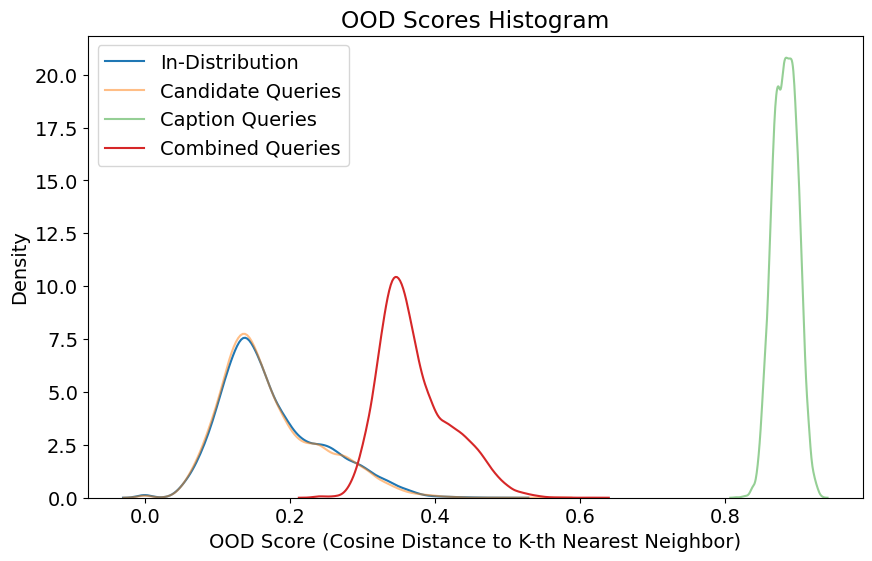

In [14]:
ood_candidate = fashion_OOD(target_features, candidate_features).cpu().detach()
ood_caption = fashion_OOD(target_features, caption_features).cpu().detach()
ood_delta = fashion_OOD(target_features, candidate_features + caption_features).cpu().detach()
ood_target = fashion_OOD(target_features, target_features).cpu().detach()

plot_histograms([ood_target, ood_candidate, ood_caption, ood_delta],
                ["In-Distribution", "Candidate Queries", "Caption Queries", "Combined Queries"],
                title="OOD Scores Histogram",
                xlabel="OOD Score (Cosine Distance to K-th Nearest Neighbor)",
                ylabel="Density",
                kde=True)

In [15]:
trg = ae_trg.cpu().detach()
cdd = ae_cdd.cpu().detach()
cap = ae_cap.cpu().detach()
retrieve = cdd + cap
intervene = cdd + bi_cap.cpu().detach()

In [16]:
cdd_score = benchmark_fashion_recall(cdd, trg)
cap_score = benchmark_fashion_recall(cap, trg)
retrieve_score = benchmark_fashion_recall(retrieve, trg)
intervene_score = benchmark_fashion_recall(intervene, trg)

  0%|                                                                                            | 0/65 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 614.80it/s]


In [17]:
print(f"Candidate Recall: {cdd_score:.4f}")
print(f"Caption Recall: {cap_score:.4f}")
print(f"Retrieve Recall: {retrieve_score:.4f}")
print(f"Intervene Recall: {intervene_score:.4f}")

Candidate Recall: 0.6837
Caption Recall: 0.6101
Retrieve Recall: 0.7862
Intervene Recall: 0.7979


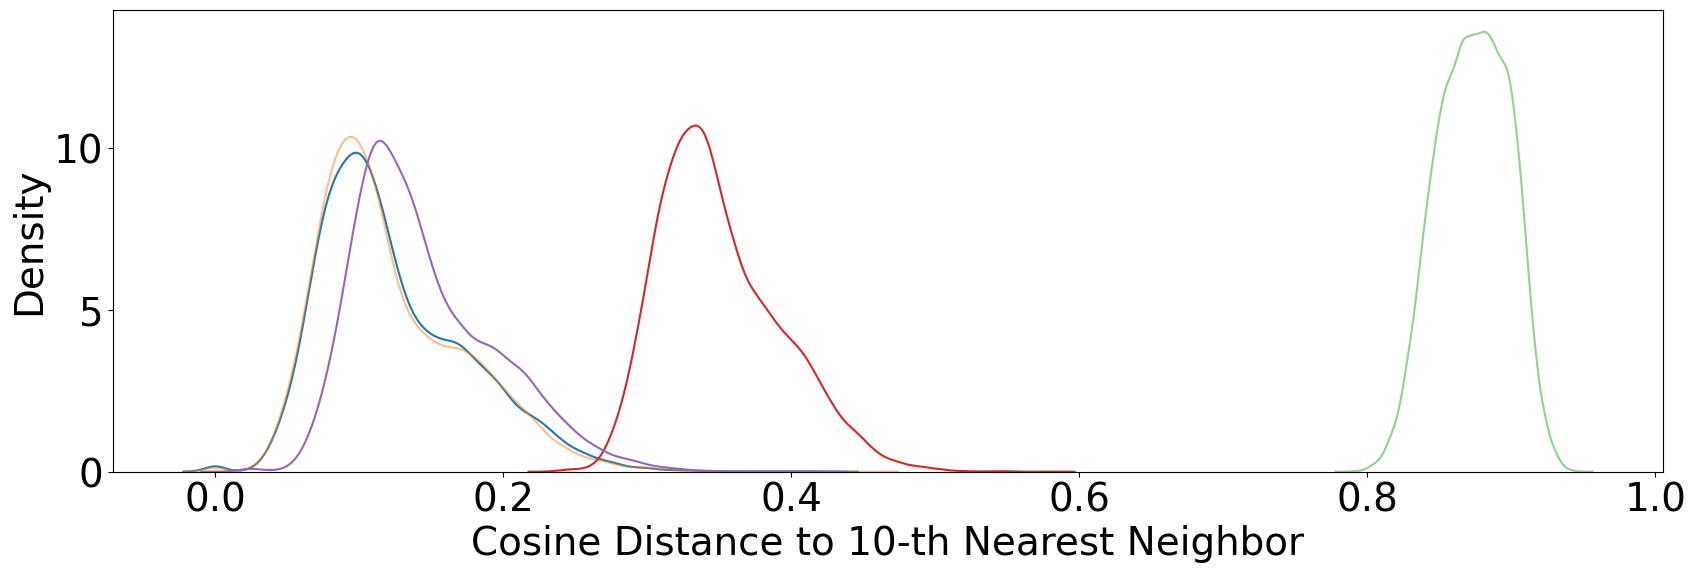

In [26]:
# ood_cdd = fashion_OOD(trg, cdd).cpu().detach()
# ood_cap = fashion_OOD(trg, cap).cpu().detach()
# ood_retrieve = fashion_OOD(trg, retrieve).cpu().detach()
# ood_intervene = fashion_OOD(trg, intervene).cpu().detach()

# id = fashion_OOD(trg, trg).cpu().detach()

plot_histograms([id, ood_cdd, ood_cap, ood_retrieve, ood_intervene],
                [r"$\widehat{T}$",
                 r"$Q^\mathrm{baseline}_{\widehat{I}_{\mathrm{src}}}$ - R@1 : " + f"{cdd_score:.2f}",
                 r"$Q^\mathrm{baseline}_{\widehat{\Delta}}$ - R@1 : " + f"{cap_score:.2f}",
                 r"$Q$ - R@1 : " + f"{retrieve_score:.2f}",
                 r"$Q_{\mathrm{SAE}}$ - R@1 : "+f"{intervene_score:.2f}"
                ],
                title="",
                xlabel="Cosine Distance to 10-th Nearest Neighbor",
                ylabel="Density",
                kde=True)

In [20]:
find_best_threshold(id, ood_cdd)
find_best_threshold(id, ood_cap)
find_best_threshold(id, ood_retrieve)
find_best_threshold(id, ood_intervene)

Best threshold: 0.0437, J-score: 0.0022, accuracy: 0.501068
Best threshold: 0.4242, J-score: 1.0000, accuracy: 0.999970
Best threshold: 0.2654, J-score: 0.9870, accuracy: 0.993473
Best threshold: 0.1076, J-score: 0.2310, accuracy: 0.615462
